# Assignment 4

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import datetime
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
batch_size = 12
device = 'gpu'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_Eurosat = torchvision.datasets.EuroSAT(root='./data',
                                        download=True, transform=transform)

classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
           'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

classes_len = len(classes)

In [3]:
generator = torch.Generator().manual_seed(42)
eurosat_train, eurosat_test = torch.utils.data.random_split(dataset_Eurosat, [0.7, 0.3], generator)

trainloader = torch.utils.data.DataLoader(eurosat_train, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(eurosat_test, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

Show sample images

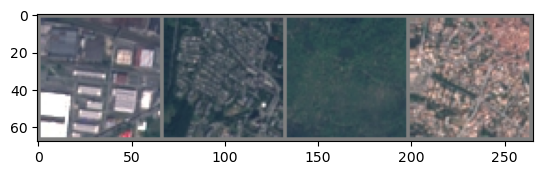

Industrial Residential Forest Residential


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[:4][j]]:5s}' for j in range(4)))

In [5]:
print("Training set: " + str(len(eurosat_train)))
print("Test set:     " + str(len(eurosat_test)))
print("---------------------------")
print("              " + str(len(eurosat_test) + len(eurosat_train)))

Training set: 18900
Test set:     8100
---------------------------
              27000


### Setup Tensorboard and Network with Batch Normalization

In [6]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S") + "_eurosat_" + device)
writer = SummaryWriter(logdir)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.batch1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.batch2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.batch3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.batch4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 13 * 13, 4096)
        self.batch5 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.batch6 = nn.BatchNorm1d(1000)
        self.fc3 = nn.Linear(1000, 10)
        # optinaler Layer
        #self.batch7 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = self.batch1(self.conv1(x))
        x = F.relu(x)
        x = self.batch2(self.conv2(x))
        x = F.relu(x)
        x = self.pool(x)
        x = self.batch3(self.conv3(x))
        x = F.relu(x)
        x = self.batch4(self.conv4(x))
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.batch5(self.fc1(x))
        #x = self.fc1(x)
        x = F.relu(x)
        x = self.batch6(self.fc2(x))
        #x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


net = Net()

In [8]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 4))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [9]:
def train(epoch, scheduler_used=False):
    
    for epoch in range(epoch):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # print statistics
            print_num = 500
            running_loss += loss.item()
            if i % print_num == (print_num-1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_num:.3f}')
                # ...log the running loss
                writer.add_scalar('training loss',
                            running_loss / print_num,
                            epoch * len(trainloader) + i)
    
                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
                running_loss = 0.0

        if scheduler_used:
            scheduler.step()
            
    print('Finished Training')

### Run and test net on GPU

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

learning_rate = 0.01 #0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

print(device)

cuda:0


In [11]:
bn_net_t_start = time.time()
train(5)
bn_net_t_end = time.time()

writer.close()

[1,   500] loss: 2.227
[1,  1000] loss: 1.402
[1,  1500] loss: 1.157
[2,   500] loss: 1.028
[2,  1000] loss: 0.884
[2,  1500] loss: 0.850
[3,   500] loss: 0.733
[3,  1000] loss: 0.723
[3,  1500] loss: 0.718
[4,   500] loss: 0.592
[4,  1000] loss: 0.585
[4,  1500] loss: 0.594
[5,   500] loss: 0.529
[5,  1000] loss: 0.504
[5,  1500] loss: 0.516
Finished Training


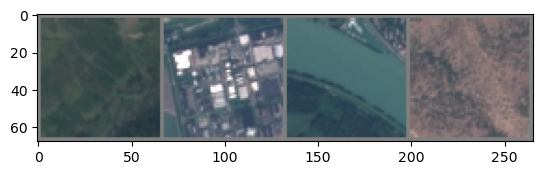

GroundTruth:  HerbaceousVegetation Industrial River HerbaceousVegetation


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[:4][j]]:5s}' for j in range(4)))

In [13]:
outputs = net(images.to(device))

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                          for j in range(4)))

Predicted:  HerbaceousVegetation Industrial River HerbaceousVegetation


In [15]:
def test(topk=False):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            if topk:
                _, predicted = torch.topk(outputs.data, 3)
                correct += predicted.eq(labels.view(-1,1).expand_as(predicted)).sum().item()
            else:    
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
            
            total += labels.size(0)
            
            #print(correct)
    acc = 100 * correct // total
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
    return acc

Testing with highest output of net

In [16]:
bn_net_acc = test()

Accuracy of the network on the 10000 test images: 78 %


Testing with top 3 outputs of net

In [17]:
bn_net_top_acc = test(topk=True)

Accuracy of the network on the 10000 test images: 96 %


In [18]:
def category_test():
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [19]:
category_test()

Accuracy for class: AnnualCrop is 86.8 %
Accuracy for class: Forest is 88.5 %
Accuracy for class: HerbaceousVegetation is 68.4 %
Accuracy for class: Highway is 70.2 %
Accuracy for class: Industrial is 90.3 %
Accuracy for class: Pasture is 72.9 %
Accuracy for class: PermanentCrop is 76.0 %
Accuracy for class: Residential is 88.2 %
Accuracy for class: River is 60.2 %
Accuracy for class: SeaLake is 88.9 %


### Train and run ResNet18 as fixed feature extractor

In [20]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)
net = model_conv
net.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S") + "_eurosat_fe_" + str(device))
writer = SummaryWriter(logdir)

resnet_fe_t_start = time.time()
train(5, scheduler_used=True)
resnet_fe_t_end = time.time()

writer.close()

[1,   500] loss: 1.119
[1,  1000] loss: 0.800
[1,  1500] loss: 0.793
[2,   500] loss: 0.731
[2,  1000] loss: 0.717
[2,  1500] loss: 0.748
[3,   500] loss: 0.716
[3,  1000] loss: 0.751
[3,  1500] loss: 0.700
[4,   500] loss: 0.723
[4,  1000] loss: 0.702
[4,  1500] loss: 0.736
[5,   500] loss: 0.699
[5,  1000] loss: 0.741
[5,  1500] loss: 0.709
Finished Training


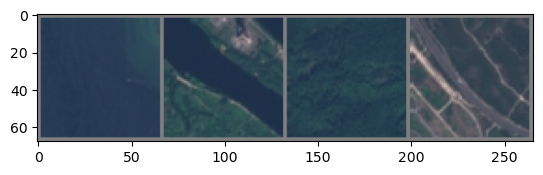

GroundTruth:  SeaLake River Forest Highway


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[:4][j]]:5s}' for j in range(4)))

In [23]:
outputs = net(images.to(device))

In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(4)))

Predicted:  SeaLake River Forest PermanentCrop


In [25]:
resnet_fe_acc = test()

Accuracy of the network on the 10000 test images: 75 %


In [26]:
resnet_fe_top_acc = test(topk=True)

Accuracy of the network on the 10000 test images: 95 %


In [27]:
category_test()

Accuracy for class: AnnualCrop is 83.2 %
Accuracy for class: Forest is 82.0 %
Accuracy for class: HerbaceousVegetation is 79.4 %
Accuracy for class: Highway is 58.2 %
Accuracy for class: Industrial is 91.0 %
Accuracy for class: Pasture is 76.6 %
Accuracy for class: PermanentCrop is 73.1 %
Accuracy for class: Residential is 78.2 %
Accuracy for class: River is 62.5 %
Accuracy for class: SeaLake is 88.7 %


### Train and run ResNet18 finetuned on training data

In [28]:
model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

net = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S") + "_eurosat_ft_" + str(device))
writer = SummaryWriter(logdir)

resnet_ft_t_start = time.time()
train(5, scheduler_used=True)
resnet_ft_t_end = time.time()

writer.close()

[1,   500] loss: 0.744
[1,  1000] loss: 0.481
[1,  1500] loss: 0.377
[2,   500] loss: 0.274
[2,  1000] loss: 0.254
[2,  1500] loss: 0.233
[3,   500] loss: 0.172
[3,  1000] loss: 0.179
[3,  1500] loss: 0.182
[4,   500] loss: 0.114
[4,  1000] loss: 0.130
[4,  1500] loss: 0.140
[5,   500] loss: 0.102
[5,  1000] loss: 0.104
[5,  1500] loss: 0.101
Finished Training


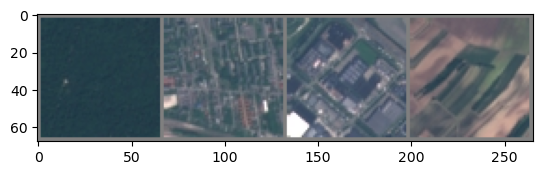

GroundTruth:  Forest Residential Industrial PermanentCrop


In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[:4][j]]:5s}' for j in range(4)))

In [31]:
outputs = net(images.to(device))

In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(4)))

Predicted:  Forest PermanentCrop Industrial PermanentCrop


In [33]:
resnet_ft_acc = test()

Accuracy of the network on the 10000 test images: 94 %


In [34]:
resnet_ft_top_acc = test(topk=True)

Accuracy of the network on the 10000 test images: 99 %


In [35]:
category_test()

Accuracy for class: AnnualCrop is 90.7 %
Accuracy for class: Forest is 97.7 %
Accuracy for class: HerbaceousVegetation is 92.5 %
Accuracy for class: Highway is 94.7 %
Accuracy for class: Industrial is 96.8 %
Accuracy for class: Pasture is 90.6 %
Accuracy for class: PermanentCrop is 88.9 %
Accuracy for class: Residential is 96.2 %
Accuracy for class: River is 92.7 %
Accuracy for class: SeaLake is 97.6 %


### Train and run EfficientNet_B5 as fixed feature extractor

In [36]:
model_conv = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 10, bias=True)

net = model_conv
net.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(net.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [37]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S") + "_eurosat_b5_fe_" + str(device))
writer = SummaryWriter(logdir)

resnet_b5_fe_t_start = time.time()
train(5, scheduler_used=True)
resnet_b5_fe_t_end = time.time()

writer.close()

[1,   500] loss: 1.701
[1,  1000] loss: 1.438
[1,  1500] loss: 1.361
[2,   500] loss: 1.321
[2,  1000] loss: 1.322
[2,  1500] loss: 1.312
[3,   500] loss: 1.307
[3,  1000] loss: 1.307
[3,  1500] loss: 1.289
[4,   500] loss: 1.275
[4,  1000] loss: 1.266
[4,  1500] loss: 1.287
[5,   500] loss: 1.283
[5,  1000] loss: 1.290
[5,  1500] loss: 1.282
Finished Training


In [38]:
resnet_b5_fe_acc = test()

Accuracy of the network on the 10000 test images: 54 %


In [39]:
resnet_b5_fe_top_acc = test(topk=True)

Accuracy of the network on the 10000 test images: 84 %


In [40]:
category_test()

Accuracy for class: AnnualCrop is 63.1 %
Accuracy for class: Forest is 73.0 %
Accuracy for class: HerbaceousVegetation is 56.0 %
Accuracy for class: Highway is 35.5 %
Accuracy for class: Industrial is 59.9 %
Accuracy for class: Pasture is 36.0 %
Accuracy for class: PermanentCrop is 39.2 %
Accuracy for class: Residential is 63.6 %
Accuracy for class: River is 43.6 %
Accuracy for class: SeaLake is 78.3 %


### Train and run EfficientNet_B5 finetuned on training data

In [41]:
model_b5_ft = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')

num_ftrs = model_b5_ft.classifier[1].in_features
model_b5_ft.classifier[1] = nn.Linear(num_ftrs, 10, bias=True)

net = model_b5_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [42]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S") + "_eurosat_b5_ft_" + str(device))
writer = SummaryWriter(logdir)

resnet_b5_ft_t_start = time.time()
train(5, scheduler_used=True)
resnet_b5_ft_t_end = time.time()

writer.close()

[1,   500] loss: 1.395
[1,  1000] loss: 0.779
[1,  1500] loss: 0.582
[2,   500] loss: 0.459
[2,  1000] loss: 0.393
[2,  1500] loss: 0.349
[3,   500] loss: 0.287
[3,  1000] loss: 0.260
[3,  1500] loss: 0.251
[4,   500] loss: 0.206
[4,  1000] loss: 0.191
[4,  1500] loss: 0.200
[5,   500] loss: 0.161
[5,  1000] loss: 0.167
[5,  1500] loss: 0.148
Finished Training


In [43]:
resnet_b5_ft_acc = test()

Accuracy of the network on the 10000 test images: 92 %


In [44]:
resnet_b5_ft_top_acc = test(topk=True)

Accuracy of the network on the 10000 test images: 99 %


In [45]:
category_test()

Accuracy for class: AnnualCrop is 89.3 %
Accuracy for class: Forest is 98.5 %
Accuracy for class: HerbaceousVegetation is 89.0 %
Accuracy for class: Highway is 94.9 %
Accuracy for class: Industrial is 93.0 %
Accuracy for class: Pasture is 92.6 %
Accuracy for class: PermanentCrop is 91.0 %
Accuracy for class: Residential is 96.7 %
Accuracy for class: River is 91.5 %
Accuracy for class: SeaLake is 95.3 %


### Summarize Results

In [57]:
print("Batch normalization net         -> time: " + str(datetime.timedelta(seconds=(bn_net_t_end - bn_net_t_start))) + " accuracy: " + str(bn_net_acc) + "%" + " top accuracy: " + str(bn_net_top_acc) + "%")
print("ResNet feature extraction       -> time: " + str(datetime.timedelta(seconds=(resnet_fe_t_end - resnet_fe_t_start))) + " accuracy: " + str(resnet_fe_acc) + "%" + " top accuracy: " + str(resnet_fe_top_acc) + "%")
print("ResNet fine tuning              -> time: " + str(datetime.timedelta(seconds=(resnet_ft_t_end - resnet_ft_t_start))) + " accuracy: " + str(resnet_ft_acc) + "%" + " top accuracy: " + str(resnet_ft_top_acc) + "%")
print("EfficientNet feature extraction -> time: " + str(datetime.timedelta(seconds=(resnet_b5_fe_t_end - resnet_b5_fe_t_start))) + " accuracy: " + str(resnet_b5_fe_acc) + "%" + " top accuracy: " + str(resnet_b5_fe_top_acc) + "%")
print("EfficientNet fine tuning        -> time: " + str(datetime.timedelta(seconds=(resnet_b5_ft_t_end - resnet_b5_ft_t_start))) + " accuracy: " + str(resnet_b5_ft_acc) + "%" + " top accuracy: " + str(resnet_b5_ft_top_acc) + "%")

Batch normalization net         -> time: 0:25:01.187353 accuracy: 78% top accuracy: 96%
ResNet feature extraction       -> time: 0:06:50.287525 accuracy: 75% top accuracy: 95%
ResNet fine tuning              -> time: 0:22:31.148173 accuracy: 94% top accuracy: 99%
EfficientNet feature extraction -> time: 0:15:39.600493 accuracy: 54% top accuracy: 84%
EfficientNet fine tuning        -> time: 1:39:25.497349 accuracy: 92% top accuracy: 99%


### Display Notebook

In [46]:
%load_ext tensorboard
%tensorboard --logdir logs

In [47]:
#notebook.display(port=6006, height=1000)